In [2]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import time
from stateSpace import stateSpaceXY
from stateValidator import stateValidator
from RRTstar import RRTstar
%matplotlib inline  


In [3]:
class Node:
    def __init__(self):
        self.cost_ = 0	
        self.parent_ = None
        self.midpoints_ = []
        self.curr_l_ = []
        self.id_ = -1
    
    def __repr__(self):
        return f"midpoints={self.midpoints_}, curr_l={self.curr_l_}, cost={self.cost_}"
		
    def plot(self):
        num_midpoints = len(self.midpoints_)
        for i in range(num_midpoints):
            plt.plot(self.midpoints_[i][:, 0], self.midpoints_[i][:, 1], '-*')

    def move_agent(self, new_pos, agent_id, max_l):
        new_node = Node()
        new_node.cost_ = self.cost_
        new_node.parent_ = self.id_
        new_node.curr_l_ = copy.deepcopy(self.curr_l_)
        new_node.midpoints_ = [np.copy(segment) for segment in self.midpoints_]
        if (0 == agent_id):
            tmp_pos = new_node.midpoints_[agent_id][0, :]
        else:
            tmp_pos = new_node.midpoints_[agent_id - 1][-1, :]
        if (calculate_distance(new_pos, tmp_pos) < 1e-3):
            return new_node
        # backward direction
        if (agent_id > 0):
            dist = np.linalg.norm(new_node.midpoints_[agent_id - 1][-1, :] - new_pos)
            new_node.cost_ += dist
            new_node.midpoints_[agent_id - 1] = np.vstack((new_node.midpoints_[agent_id - 1], new_pos))
            new_node.curr_l_[agent_id - 1] += dist
            for i in range(agent_id - 1, -1, -1):
                if new_node.curr_l_[i] > max_l:
                    to_move = new_node.curr_l_[i] - max_l
                    new_node.cost_ += to_move
                    if (i > 0):
                        new_node.curr_l_[i - 1] += to_move
                    to_add = []
                    num_mid_point = new_node.midpoints_[i].shape[0]
                    for j in range(num_mid_point - 1):
                        dist = np.linalg.norm(new_node.midpoints_[i][j, :] - new_node.midpoints_[i][j + 1, :])
                        if dist > to_move + 1e-3:
                            # interpolation
                            temp = (new_node.midpoints_[i][j + 1, :] - new_node.midpoints_[i][j, :]) * to_move / dist + new_node.midpoints_[i][j, :]
                            if (i > 0):
                                to_add.append(temp)
                                new_node.midpoints_[i - 1] = np.vstack((new_node.midpoints_[i - 1], np.array(to_add)))

                            new_node.midpoints_[i] = np.vstack((temp, new_node.midpoints_[i][j + 1 :, :]))
                            new_node.curr_l_[i] = max_l
                            break
                        elif dist < to_move - 1e-3:
                            to_move -= dist
                            if (i > 0):
                                to_add.append(new_node.midpoints_[i][j + 1, :])
                        else:
                            if (i > 0):
                                to_add.append(new_node.midpoints_[i][j + 1, :])
                                new_node.midpoints_[i - 1] = np.vstack((new_node.midpoints_[i - 1], np.array(to_add)))
                            new_node.midpoints_[i] = new_node.midpoints_[i][:j + 1, :]
                            new_node.curr_l_[i] = max_l
                            break
                else:
                    break
            
        # forward direction
        if (agent_id < len(self.midpoints_)):
            dist = np.linalg.norm(new_node.midpoints_[agent_id][0] - new_pos)
            new_node.cost_ += dist
            new_node.midpoints_[agent_id] = np.vstack((new_pos, new_node.midpoints_[agent_id]))
            new_node.curr_l_[agent_id] += dist
            for i in range(agent_id, len(self.midpoints_)):
                if new_node.curr_l_[i] > max_l:
                    to_move = new_node.curr_l_[i] - max_l
                    new_node.cost_ += to_move
                    if (i < len(self.midpoints_) - 1):
                        new_node.curr_l_[i + 1] += to_move
                    to_add = []
                    num_mid_point = new_node.midpoints_[i].shape[0]
                    for j in range(num_mid_point - 1, 0, -1):
                        dist = np.linalg.norm(new_node.midpoints_[i][j, :] - new_node.midpoints_[i][j - 1, :])
                        if dist > to_move + 1e-3:
                            # interpolation
                            temp = (new_node.midpoints_[i][j - 1, :] - new_node.midpoints_[i][j, :]) * to_move / dist + new_node.midpoints_[i][j, :]
                            if (i < len(self.midpoints_) - 1):
                                to_add = [temp] + to_add
                                new_node.midpoints_[i + 1] = np.vstack((np.array(to_add), new_node.midpoints_[i + 1]))

                            new_node.midpoints_[i] = np.vstack((new_node.midpoints_[i][:j, :], temp))
                            new_node.curr_l_[i] = max_l
                            break
                        elif dist < to_move - 1e-3:
                            to_move -= dist
                            if (i < len(self.midpoints_) - 1):
                                to_add.append(new_node.midpoints_[i][j - 1, :])
                        else:
                            if (i < len(self.midpoints_) - 1):
                                to_add.append(new_node.midpoints_[i][j - 1, :])
                                new_node.midpoints_[i + 1] = np.vstack((new_node.midpoints_[i + 1], np.array(to_add)))
                            new_node.midpoints_[i] = new_node.midpoints_[i][:j, :]
                            new_node.curr_l_[i] = max_l
                            break
                else:
                    break
            
        return new_node
    
def calculate_distance(x1, x2):
    return np.linalg.norm(x1 - x2)

In [4]:
class TRRTstar:
	def __init__(self, num_agents, start, goal, ss, sv, \
		move_weight, max_l, max_iter = 500, expand_range = 20, \
		ball_radius = 200, if_shorten = False,
		goal_bias_freq = 100,
		if_improve_after_reach = False):
		"""
		num_agents: # of agents
		start: start position (num_agents * 2)
		goal: target position [x, y]
		ss: state space 
		sv: state validator 
		"""
		self.num_agents_ = num_agents
		self.points_ = start 
		self.goal_ = goal
		self.ss_ = ss 
		self.sv_ = sv 
		self.move_weight_ = move_weight
		self.max_l_ = max_l
		self.max_iter_ = max_iter
		self.expand_range_ = expand_range
		self.ball_radius_ = ball_radius
		self.if_shorten_ = if_shorten
		node_start = Node()
		node_start.parent_ = -1
		for i in range(num_agents - 1):
			node_start.curr_l_.append(calculate_distance(start[0, i, :], start[0, i + 1, :]))
			node_start.midpoints_.append(start[0, i:i+2, :])
		self.node_list_ = [node_start]
		self.goal_bias_freq_ = goal_bias_freq
		self.if_improve_after_reach_ = if_improve_after_reach
	
	def planning(self):
		# need to be modified to goal bias
		for i in range(self.max_iter_):
			if 0 == i % self.goal_bias_freq_:
				if_reached = self.planning_point_assign(self.goal_, 0)
				if_close =  calculate_distance(self.points_[-1, 0, :], self.goal_) < 0.01
				if if_reached and if_close:
					print("reached goal at iteration ", i)
					break
				else:
					continue
			new_pos = self.ss_.sampleUniform()
			# new_pos = self.ss.sampleHalton(i)	
			while not self.sv_.isMotionValid(new_pos, new_pos):
				new_pos = self.ss_.sampleUniform()
			self.planning_point(new_pos)
		if_reached = self.planning_point_assign(self.goal_, 0)
		if_close =  calculate_distance(self.points_[-1, 0, :], self.goal_) < 0.01
		# if reached needs to be fixed
		return (if_reached and if_close)

	def shortening(self, node):
		# curve shortening algorithm
		curr_l = node.curr_l_
		temp_midpoints_ = []
		temp_curr_l = []
		for i in range(self.num_agents_ - 1):
			num_midpoints_ = node.midpoints_[i].shape[0]
			if num_midpoints_ > 2:
				to_delete = []
				point1 = node.midpoints_[i][0, :]
				point2 = node.midpoints_[i][1, :]
				point3 = node.midpoints_[i][2, :]
				for j in range(num_midpoints_ - 2):
					if self.if_shorten_valid(point1, point2, point3):
						to_delete.append(j + 1)
					else:
						point1 = point2
					point2 = point3
					point3 = node.midpoints_[i][j + 2, :]
				node.midpoints_[i] = np.delete(node.midpoints_[i], to_delete, 0)
				num_midpoints_ = node.midpoints_[i].shape[0]
				temp_l = 0
				for j in range(num_midpoints_ - 1):
					temp_l += calculate_distance(node.midpoints_[i][j, :], \
						node.midpoints_[i][j + 1, :])
				node.curr_l_[i] = temp_l
		return node

			
	def if_shorten_valid(self, point1, point2, point3):
		if not self.sv_.isMotionValid(point1, point3):
			return False
		if self.sv_.isObstacleInTriangle(point1, point2, point3):
			return False
		return True


	def planning_point(self, new_pos):
		"""
		main planning algorithm
		"""
		# for i in range(self.max_iter):
		# 	if np.random.rand() > 0.99:
		# 		new_pos = self.goal
		# 	else:
		# 		new_pos = self.ss.sampleUniform()
			# while not self.sv.isStateValid(new_pos, new_pos):
			# 	new_pos = self.ss.sampleUniform()
	
		temp_dist = np.Inf
		temp_near_list = []

		num_node = len(self.node_list_)
		curr_ball_radius = (np.log(num_node + 1) / num_node) ** 0.5 \
			* self.ball_radius_

		for j in range(self.num_agents_):
			diff = np.linalg.norm(self.points_[:, j, :] - new_pos, axis = 1)
			temp_nearest = np.argmin(diff)
	
			if diff[temp_nearest] * self.move_weight_[j] < temp_dist:
				temp_move = j
				temp_id = temp_nearest
				temp_dist = diff[temp_nearest] * self.move_weight_[j]
			temp_near_list.append(np.where(diff <= curr_ball_radius)[0])
		nearest_pos = self.points_[temp_id, temp_move, :]
		new_pos = self.steer(nearest_pos, new_pos)

		if self.sv_.isMotionValid(new_pos, nearest_pos):
			new_node, new_point = self.calculate_cost(temp_id, temp_move, new_pos)
			for j in range(self.num_agents_):
				num_list = temp_near_list[j].shape[0]
				for k in range(num_list):
					ind = temp_near_list[j][k]
					near_pos = self.points_[ind, j, :]
					if self.sv_.isMotionValid(new_pos, near_pos):
						temp_node, temp_point = self.calculate_cost(ind, j, new_pos)
						if temp_node.cost_ < new_node.cost_:
							new_node = temp_node
							# new_node.parent = ind
							new_point = temp_point
			new_node.id_ = len(self.node_list_)
			self.node_list_.append(new_node)
			self.points_ = np.append(self.points_, new_point.reshape(1, self.num_agents_,2), axis = 0)
			return True
		else:
			return False
		
	def planning_point_assign(self, new_pos, assign_agent):
		"""
		main planning algorithm
		"""
		# for i in range(self.max_iter):
		# 	if np.random.rand() > 0.99:
		# 		new_pos = self.goal
		# 	else:
		# 		new_pos = self.ss.sampleUniform()
			# while not self.sv.isStateValid(new_pos, new_pos):
			# 	new_pos = self.ss.sampleUniform()
	
		temp_dist = np.Inf
		temp_near_list = []

		num_node = len(self.node_list_)
		curr_ball_radius = (np.log(num_node + 1) / num_node) ** 0.5 \
			* self.ball_radius_

		j = assign_agent
		diff = np.linalg.norm(self.points_[:, j, :] - new_pos, axis = 1)
		temp_nearest = np.argmin(diff)

		if diff[temp_nearest] * self.move_weight_[j] < temp_dist:
			temp_move = j
			temp_id = temp_nearest
			temp_dist = diff[temp_nearest] * self.move_weight_[j]
		temp_near_list.append(np.where(diff <= curr_ball_radius)[0])
		nearest_pos = self.points_[temp_id, temp_move, :]
		new_pos = self.steer(nearest_pos, new_pos)

		if self.sv_.isMotionValid(new_pos, nearest_pos):
			new_node, new_point = self.calculate_cost(temp_id, temp_move, new_pos)
			num_list = temp_near_list[j].shape[0]
			for k in range(num_list):
				ind = temp_near_list[j][k]
				near_pos = self.points_[ind, j, :]
				if self.sv_.isMotionValid(new_pos, near_pos):
					temp_node, temp_point = self.calculate_cost(ind, j, new_pos)
					if temp_node.cost_ < new_node.cost_:
						new_node = temp_node
						# new_node.parent = ind
						new_point = temp_point
			new_node.id_ = len(self.node_list_)
			self.node_list_.append(new_node)
			self.points_ = np.append(self.points_, new_point.reshape(1, self.num_agents_,2), axis = 0)
			return True
		else:
			return False

	def calculate_cost(self, node_id, temp_move, new_pos):
		new_node = self.node_list_[node_id].move_agent(new_pos, temp_move, self.max_l_)
		new_points = []
		for i in range(self.num_agents_ - 1):
			new_points.append(new_node.midpoints_[i][0, :].tolist())
		new_points.append(new_node.midpoints_[-1][-1, :].tolist())
		return new_node, np.array(new_points)

	def steer(self, start_point, end_point):
		d = np.linalg.norm(end_point - start_point)
		if d > self.expand_range_:
			end_point = start_point + self.expand_range_ / d * (end_point \
				-start_point)
		return end_point	


In [5]:
def plan_subsequent_agents_rev(start, goal, ss, sv, max_l,
                           curr_node, agent_id, max_iter = 100):
    # assuming the agent i is already planned
    # then for agent i + 1/i - 1,
    # the start is the goal of agent i + 1/i - 1
    # the goal is the goal of agent i
    planner = RRTstar(start, goal, ss, sv, max_iter)
    if_reached = planner.planning()
    end_node = planner.node_list[-1]
    # if the planner return false for planning or
    # if the agent reached but with the cost larger than max_l
    # then return false
    pos_moved = []
    if (not if_reached) or end_node.cost > max_l:
        if_reached = False
    else:
        curr_l = curr_node.curr_l_[agent_id]
        temp_l = 0
        curr_cost = curr_l + end_node.cost
        mid_points = curr_node.midpoints_[agent_id]
        num_mid_points = mid_points.shape[0]
        # need to adjust based on the order
        final_pos_id = 0
        final_position = mid_points[final_pos_id]
        final_goal_id = len(planner.node_list) - 1
        final_id = final_goal_id
        for i in range(num_mid_points - 1 , 1, -1):
            temp_short = np.linalg.norm(mid_points[i, :]\
                                       - mid_points[i-1, :])
            temp_l = temp_l + temp_short
            temp_reach = planner.planning_point(mid_points[i- 1, :])
            if temp_reach:
                temp_node = planner.node_list[-1]
                if temp_node.cost + temp_l > max_l:
                    # sample from the line segment
                    # num of samples ned to be adjusted
                    for j in range(20):
                        rand_ratio = np.random.rand()
                        temp_pos = mid_points[i-1, :] + rand_ratio * \
                        (mid_points[i, :]\
                                       - mid_points[i-1, :])
                        temp_len = temp_l - (1 - rand_ratio) * temp_short
                        temp_reach2 = planner.planning_point(temp_pos)
                        if temp_reach2 and planner.node_list[-1].cost + temp_len <= max_l and \
                        curr_l + planner.node_list[-1].cost - temp_len < curr_cost:
                            curr_cost = curr_l + temp_node.cost - temp_len
                            final_node = planner.node_list[-1]
                            final_pos = i
                            final_position = temp_pos
                            final_id = len(planner.node_list) - 1
                elif curr_l + temp_node.cost - temp_l < curr_cost:
                    curr_cost = curr_l + temp_node.cost - temp_l
                    final_node = planner.node_list[-1]
                    final_pos = i
                    final_position = mid_points[i, :]
                    final_id = len(planner.node_list) - 1
        curr_id = final_id
        cur_node = planner.node_list[curr_id]
        # for j in range(i - 1, -1, -1):
        #     pos_moved.append(mid_points[j, :])
        pos_moved.append(planner.points[curr_id, :])
        while cur_node.parent != -1:
            parent_id = cur_node.parent
            # x_pos = [cur_node.pos[0], planner.node_list[parent_id].pos[0]]
            # y_pos = [cur_node.pos[1], planner.node_list[parent_id].pos[1]]
            curr_id = parent_id
            cur_node = planner.node_list[curr_id]
            pos_moved.append(planner.points[curr_id, :])
    return if_reached, pos_moved

In [6]:
def run_sim(num_agents = 20):
    # Initialize the map
    yMax = 200
    xMax = 200
    # np.random.seed(1)
    state_bounds = np.array([[0, xMax], [0, yMax]])
    ss = stateSpaceXY(state_bounds)
    # start = np.array([[[20, 150], [17.5, 125], [15, 100], [12.5, 75], [10, 50]]])
    start_start = np.array([20, 150])
    start_end = np.array([10, 50])


    assign_agent = 0
    max_l = 100
    move_weight = [2 for i in range(num_agents)]
    move_weight[0] = 1
    move_weight[-1] = 1
    # Generate 20 points between start and end
    start = np.linspace(start_start, start_end, num_agents)# goal = np.array([175, 175])
    start = start.reshape(1, num_agents, 2)
    # goal1 = np.array([125, 125])
    # start2 = np.array([[20, 150]])

    goals = np.zeros((num_agents, 2))
    goal0 = np.array([175, 175])
    goal1 = np.array([172.5, 135])
    num_gap = int(num_agents / 4) + 1
    tmp_0 = np.linspace(goal0, goal1, num_gap)
    goals[0:num_gap-1, :] = tmp_0[0:num_gap-1, :]
    goal2 = np.array([170, 100])
    tmp_1 = np.linspace(goal1, goal2, num_gap)
    goals[num_gap-1:2*num_gap-2, :] = tmp_1[0:num_gap-1, :]
    goal3 = np.array([160, 75])
    tmp_2 = np.linspace(goal2, goal3, num_gap)
    goals[2*num_gap-2:3*num_gap-3, :] = tmp_2[0:num_gap-1, :]
    goal4 = np.array([150, 50])
    tmp_3 = np.linspace(goal3, goal4, num_gap)
    goals[3*num_gap-3:4*num_gap-4, :] = tmp_3[0:num_gap-1, :]

    def generate_obs(num_obs):
        # Currently circle
        obstacles = np.array([[50, 150, 15], [60, 85, 10], [150, 100, 15]])
        for i in range(num_obs):
            px = 15 + np.random.rand() * 170
            py = np.random.rand() * 200
            ra = 5 + np.random.rand() * 5
            obstacles = np.concatenate((obstacles, np.array([[px, py, ra]])), axis = 0)
        sv = stateValidator(ss, obstacles)
        return obstacles, sv

    num_obs = 15
    generate_success = False

    # check if the start and end are valid
    while (not generate_success):
        obstacles, sv = generate_obs(num_obs)
        generate_success = True
        for i in range(num_agents):
            if not sv.isMotionValid(start[0, i, :], start[0, i, :]):
                generate_success = False
                break
            if not sv.isMotionValid(goals[i, :], goals[i, :]):
                generate_success = False
                break
        
        for i in range(num_agents - 1):
            if not sv.isMotionValid(start[0, i, :], start[0, i + 1, :]):
                generate_success = False
                break
            if not sv.isMotionValid(goals[i, :], goals[i + 1, :]):
                generate_success = False
                break
        

    node_start = Node()
    node_start.curr_l = []
    node_start.mid_points = []
    node_start.parent = -1
    for i in range(num_agents - 1):
        node_start.curr_l.append(calculate_distance(start[0, i, :], start[0, i + 1, :]))
        node_start.mid_points.append(start[0, i:i+2, :])
    planner = TRRTstar(num_agents, start, goal0, ss, sv, move_weight, max_l, max_iter = 500, ball_radius = np.inf)

    t_start = time.time()  
    if_reached = planner.planning()
    end_node = planner.node_list_[-1]
    new_node = copy.deepcopy(end_node)
    for i in range(1, num_agents):
        if (if_reached):
            s = np.array([goals[i, :]])
            g = new_node.midpoints_[i - 1][0, :]
            if_reached, pos_moved = plan_subsequent_agents_rev(s, g, ss, sv, max_l,
                                    new_node, i - 1, max_iter = 100)
            
            for j in range(0, len(pos_moved)):
                tmp_node = new_node.move_agent(pos_moved[j], i, max_l)
                new_node = copy.deepcopy(tmp_node)
        else:
            break
    t_end = time.time()
    print(f'If reached: {if_reached}')

    if (if_reached):
        duration = t_end - t_start
        print(f'Duration: {duration}')
    return  if_reached, duration

In [8]:
run_times = 20
d_20 = []
for i in range(run_times):
    if_reached, duration = run_sim()
    if (if_reached):
        print(f'Success in {i}th iteration')
        d_20.append(duration)

print(d_20)
print(f'Number of success: {len(d_20)}')
print(f'Average duration: {np.mean(d_20)}')
print(f'Std: {np.std(d_20)}')
print(f'Min: {np.min(d_20)}')
print(f'Max: {np.max(d_20)}')

d_28 = []
for i in range(20):
    if_reached, duration = run_sim(28)
    if (if_reached):
        print(f'Success in {i}th iteration')
        d_28.append(duration)

print(d_28)
print(f'Number of success: {len(d_28)}')
print(f'Average duration: {np.mean(d_28)}')
print(f'Std: {np.std(d_28)}')
print(f'Min: {np.min(d_28)}')
print(f'Max: {np.max(d_28)}')

d_36 = []
for i in range(run_times):
    if_reached, duration = run_sim(36)
    if (if_reached):
        print(f'Success in {i}th iteration')
        d_36.append(duration)




d_48 = []
for i in range(run_times):
    if_reached, duration = run_sim(48)
    if (if_reached):
        print(f'Success in {i}th iteration')
        d_48.append(duration)

print(d_48)
print(f'Number of success: {len(d_48)}')
print(f'Average duration: {np.mean(d_48)}')
print(f'Std: {np.std(d_48)}')
print(f'Min: {np.min(d_48)}')
print(f'Max: {np.max(d_48)}')


reached goal at iteration  100
If reached: True
Duration: 18.605777740478516
Success in 0th iteration
[18.605777740478516]
Number of success: 1
Average duration: 18.605777740478516
Std: 0.0
Min: 18.605777740478516
Max: 18.605777740478516


midpoints=[array([[0, 0],
       [5, 0]]), array([[ 5,  0],
       [10,  0]])], curr_l=[5.0, 5.0], cost=0
midpoints=[array([[0, 0],
       [5, 0],
       [5, 5]]), array([[ 5,  5],
       [ 5,  0],
       [10,  0]])], curr_l=[10.0, 10.0], cost=10.0


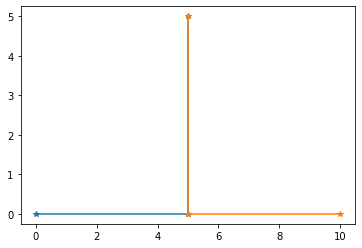

In [9]:
# Test 1, mid agent within range
max_l = 10
num_agents = 3
# Give a node
pos = np.array([[0, 0], [5, 0], [10, 0]])
n0 = Node()
for i in range(num_agents - 1):
    n0.midpoints_.append(pos[i : i + 2, :])
    n0.curr_l_.append(np.linalg.norm(pos[i + 1, :] - pos[i, :]))

# n0.plot()
n1 = n0.move_agent(np.array([5, 5]), 1, max_l)
n1.plot()
print(n0)
print(n1)

midpoints=[array([[0, 0],
       [5, 0]]), array([[ 5,  0],
       [10,  0]])], curr_l=[5.0, 5.0], cost=0
midpoints=[array([[2.07106781, 0.        ],
       [5.        , 0.        ],
       [0.        , 5.        ]]), array([[0.        , 5.        ],
       [5.        , 0.        ],
       [7.92893219, 0.        ]])], curr_l=[10, 10], cost=18.284271247461902


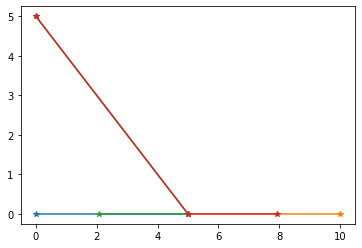

In [10]:
# Test 2, mid agent beyond range
max_l = 10
num_agents = 3
# Give a node
pos = np.array([[0, 0], [5, 0], [10, 0]])
n0 = Node()
for i in range(num_agents - 1):
    n0.midpoints_.append(pos[i : i + 2, :])
    n0.curr_l_.append(np.linalg.norm(pos[i + 1, :] - pos[i, :]))

n0.plot()
n1 = n0.move_agent(np.array([0, 5]), 1, max_l)
n1.plot()
print(n0)
print(n1)

midpoints=[array([[0, 0],
       [5, 0]]), array([[ 5,  0],
       [10,  0]])], curr_l=[5.0, 5.0], cost=0
midpoints=[array([[0, 5],
       [0, 0],
       [5, 0]]), array([[ 5,  0],
       [10,  0]])], curr_l=[10.0, 5.0], cost=5.0


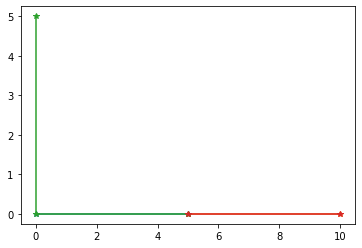

In [11]:
# Test 3, first agent within range
max_l = 10
num_agents = 3
# Give a node
pos = np.array([[0, 0], [5, 0], [10, 0]])
n0 = Node()
for i in range(num_agents - 1):
    n0.midpoints_.append(pos[i : i + 2, :])
    n0.curr_l_.append(np.linalg.norm(pos[i + 1, :] - pos[i, :]))

n0.plot()
n1 = n0.move_agent(np.array([0, 5]), 0, max_l)
n1.plot()
print(n0)
print(n1)

midpoints=[array([[0, 0],
       [5, 0]]), array([[ 5,  0],
       [10,  0]])], curr_l=[5.0, 5.0], cost=0
midpoints=[array([[ 3.        ,  0.        ],
       [ 5.        ,  0.        ],
       [10.        ,  0.        ],
       [12.76923077,  1.15384615]]), array([[12.76923077,  1.15384615],
       [22.        ,  5.        ]])], curr_l=[10, 10], cost=24.0


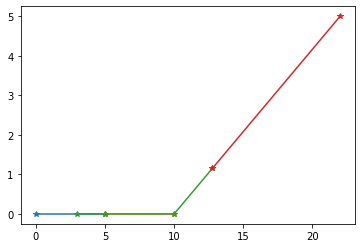

In [12]:
# Test 4, last agent within range
max_l = 10
num_agents = 3
# Give a node
pos = np.array([[0, 0], [5, 0], [10, 0]])
n0 = Node()
for i in range(num_agents - 1):
    n0.midpoints_.append(pos[i : i + 2, :])
    n0.curr_l_.append(np.linalg.norm(pos[i + 1, :] - pos[i, :]))

n0.plot()
n1 = n0.move_agent(np.array([22, 5]), 2, max_l)
n1.plot()
print(n0)
print(n1)

midpoints=[array([[ 5.18033989,  0.        ],
       [10.        ,  0.        ],
       [ 7.15541753,  1.42229124]]), array([[7.15541753, 1.42229124],
       [0.        , 5.        ]]), array([[0.        , 5.        ],
       [7.15541753, 1.42229124]]), array([[ 7.15541753,  1.42229124],
       [10.        ,  0.        ],
       [14.81966011,  0.        ]])], curr_l=[8, 8, 8, 8], cost=49.08203932499369


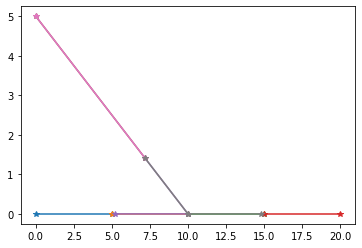

In [13]:
# Test 5
max_l = 8
num_agents = 5
# Give a node
pos = np.array([[0, 0], [5, 0], [10, 0], [15, 0], [20, 0]])
n0 = Node()
for i in range(num_agents - 1):
    n0.midpoints_.append(pos[i : i + 2, :])
    n0.curr_l_.append(np.linalg.norm(pos[i + 1, :] - pos[i, :]))
n0.plot()
n1 = n0.move_agent(np.array([0, 5]), 2, max_l)
n1.plot()
print(n1)